In [3]:
import numpy as np
import pandas as pd

In [4]:
dt=pd.read_csv('dt.csv')

In [ ]:
dt

,date,weighted_sentiment
0,2023-06-01,0.000000
1,2023-06-02,0.000000
2,2023-06-03,0.000000
3,2023-06-04,0.000000
4,2023-06-05,0.000000
...,...,...
637,2025-02-27,-0.043340
638,2025-02-28,-0.011422
639,2025-03-01,0.024521
640,2025-03-02,0.054738


In [5]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
from datetime import datetime

# 1. Download historical stock data for Reliance Industries
# "RELIANCE.NS" is typically used for Reliance Industries on the NSE.
start_date = "2019-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")
ticker = "RELIANCE.NS"

# Download data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
# Reset the index of the downloaded data to have a single-level index
df = data.reset_index()[["Date", "Close"]].rename(columns={"Date": "date", "Close": "y"})
df['date']=pd.to_datetime(df['date'])
dt['date']=pd.to_datetime(dt['date'])
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
#Now the merge should work as both DataFrames have a single level index
df = df.merge(dt, on='date', how='left').fillna(0)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df=df[['date','y','weighted_sentiment']]

In [7]:
dt=df[['weighted_sentiment','date','y']]

In [8]:
dt2=dt.iloc[:-30,:]

In [9]:
dt3=dt['weighted_sentiment']
dt3=dt3.iloc[-30:]
dt3=dt3.to_numpy()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1498
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6311.606
Date:                            Fri, 07 Mar 2025   AIC                          12635.212
Time:                                    14:43:35   BIC                          12667.031
Sample:                                         0   HQIC                         12647.072
                                           - 1498                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
weighted_sentiment    16.9261     10.331      1.638      0.101      -3.322      37.175
ar.L1      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


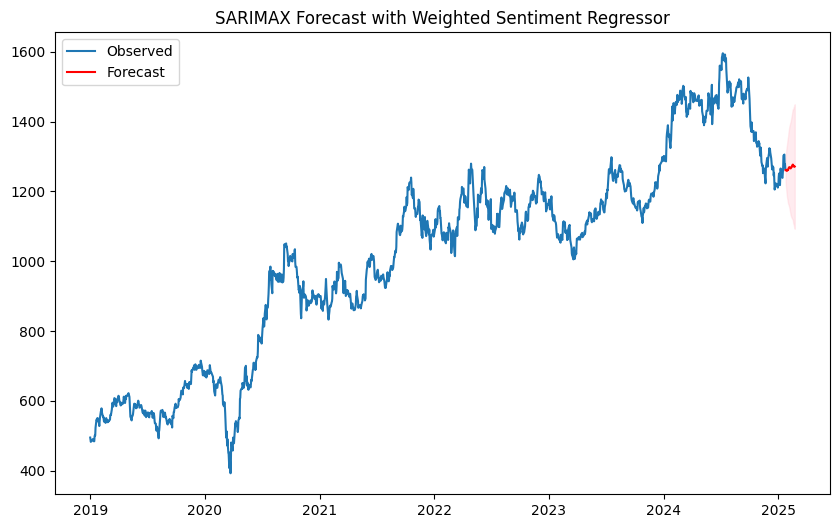

1498    1260.610379
1499    1260.528418
1500    1261.902675
1501    1260.578671
1502    1258.786439
1503    1259.332321
1504    1261.420319
1505    1260.992334
1506    1261.455165
1507    1265.999080
1508    1266.632470
1509    1268.798017
1510    1269.599565
1511    1268.691443
1512    1267.694972
1513    1267.168959
1514    1265.760277
1515    1267.351029
1516    1267.982680
1517    1270.558373
1518    1270.876473
1519    1273.892811
1520    1275.588979
1521    1276.763071
1522    1272.589051
1523    1272.336676
1524    1273.436639
1525    1271.179119
1526    1270.143813
1527    1271.191909
Name: predicted_mean, dtype: float64


In [10]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
dt2.set_index('date', inplace=True)

# Define the exogenous variables
exog = dt2['weighted_sentiment']
y = dt2['y']

# --- Step 2: Fit a SARIMAX Model ---
# Here we choose a simple order and seasonal order (adjust as needed).
# order=(p,d,q) and seasonal_order=(P,D,Q,s) where s is the seasonality period.
model = sm.tsa.SARIMAX(y, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)
print(results.summary())

# --- Step 3: Forecast Future Values ---
# Forecast 45 days ahead.

# Create future dates
future_dates = pd.date_range(start=dt2.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Prepare future exogenous values.
# Here, we fill with the historical mean (replace with your forecast if available).
future_exog = pd.DataFrame({
    'weighted_sentiment': dt3
}, index=future_dates)

# Generate forecast.
forecast_obj = results.get_forecast(steps=30, exog=future_exog)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# Plot the results.
plt.figure(figsize=(10, 6))
plt.plot(dt2.index, y, label='Observed')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')
plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMAX Forecast with Weighted Sentiment Regressor")
plt.show()

# Print forecasted values.
print(forecast_mean)


In [11]:
results.save("sarimax_model.pkl")


In [12]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(dt.iloc[-30:,2],forecast_mean)

In [13]:
print(mae)

41.07377407199184


In [14]:
forecast_mean.mean()

1267.3280708846619

In [17]:
4107.377407199184/1255.5718162335247

3.271320169897195